# Desafío Final: Fake News Detector

**Objetivo:** Armar un clasificador que detecte Fake News.

## 1) Importamos las librerías que vamos a utilizar

In [17]:
import pandas as pd
import os
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 2) Importamos el dataset que contiene las noticias en inglés.

In [3]:
df_fn2 = pd.read_csv('FakeNews2/train.csv')
df_fn2

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


## 3) Comprobamos si las clases están balanceadas

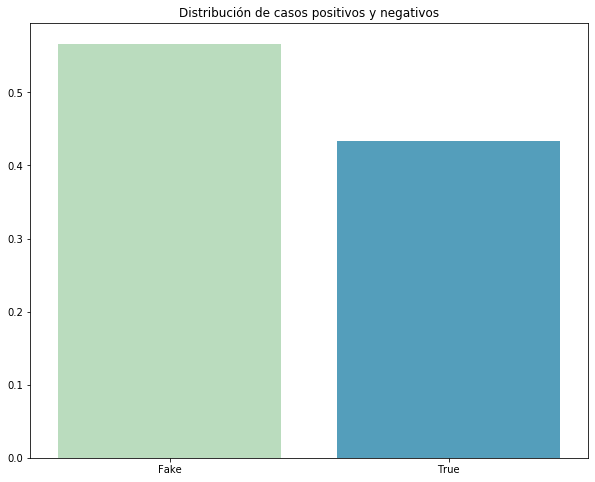

In [56]:
plt.figure(figsize=(10,8))
plt.title('Distribución de casos positivos y negativos')
sns.barplot(['Fake', 'True'], df_fn2.label.value_counts(normalize=True).values, palette='GnBu');
plt.savefig('classes_balance.png')

## 4) Agrupamos por autor para ver qué cantidad de fake news tiene etiquetadas

In [67]:
df_fn2.groupby('author')[['label']].describe().sort_values(('label', 'mean'), ascending=False)

label                                   
                              count mean  std  min  25%  50%  75%  max
author                                                                
# 1 NWO Hatr                   17.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
Lisa Tanner                     3.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
Linda S. Heard                  2.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
Lindsay Hayward                 2.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
Linh Dinh                       4.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
...                             ...  ...  ...  ...  ...  ...  ...  ...
Cinthia Ritchie                 1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0
Liz Robbins                     7.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
Liz Robbins and Annie Correal   1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0
Liz Spayd                      13.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
Karen Workman and David Scull   1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0

[3838 rows x 8 columns]

Podemos observar que tenemos 3838 autores indivduales. En nuestro dataset, el hecho que tome valor 1, significa que la noticia es verídica, mientras que 0 corresponde a Fake.

## 5) Eliminamos los NaN's
Aproximadamente unas 2000 observaciones (10%)

In [4]:
df_fn2.dropna(inplace=True)

## 6) Definimos nuestras variables explicativas (features) y dependientes (objetivo)
A efectos de simplificar el modelo, utilizamos sólo la información del texto de la nota. Por otra parte, la variable objetivo es `label`.
Una vez elegidas nuestras variables, hacemos un split del dataset para poder calcular el poder de predicción del modelo.


Mejora simple: incluir stopwords

In [5]:
X = df_fn2['text']
y = df_fn2['label']
X_train, X_test, y_train, y_test = train_test_split(X,y)

## 7) Vectorizamos el texto utilizando TF-IDF
Debido a que nuestras features dependen del texto escrito en la nota, necesitamos convertirlo en un vector. Para ello, instanciamos la clase TfidVectorizer que calcula las frecuencias relativas de las palabras y n-gramas de los textos y los representa de forma matricial.

Primero hacemos un `.fit_transform()` a efectos de que utilice todas las palabras del set de entrenamiento.

In [6]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train)

Una vez vectorizadas las palabras del set de entramiento, hacemos un `.transform()` sobre los textos de test. Lo que fuerza a que pierda las palabras nuevas que no están en dichas notas.

In [7]:
X_test = vectorizer.transform(X_test)

Vemos la forma del set de entrenamiento y de validación

In [8]:
X_train.shape, X_test.shape

((13713, 2677790), (4572, 2677790))

## 8) Instanciamos los algoritmos que vamos a utilizar para fittear el modelo.
Por motivos de simplificación y de recursos, no hacemos cross-validation para encontrar los hiper-parámetros óptimos, así como tampoco probamos el resto de los algoritmos.

In [9]:
etc = ExtraTreesClassifier()
forest = RandomForestClassifier(n_estimators=1000, n_jobs=20)
GBoost = GradientBoostingClassifier()

Fitteamos el modelo

In [10]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=20, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Predecimos en base al modelo fitteado.

In [11]:
y_hat = forest.predict(X_test)

## 9) Evaluamos la capacidad predictora del modelo

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2579
           1       0.97      0.82      0.89      1993

    accuracy                           0.91      4572
   macro avg       0.92      0.90      0.90      4572
weighted avg       0.91      0.91      0.91      4572



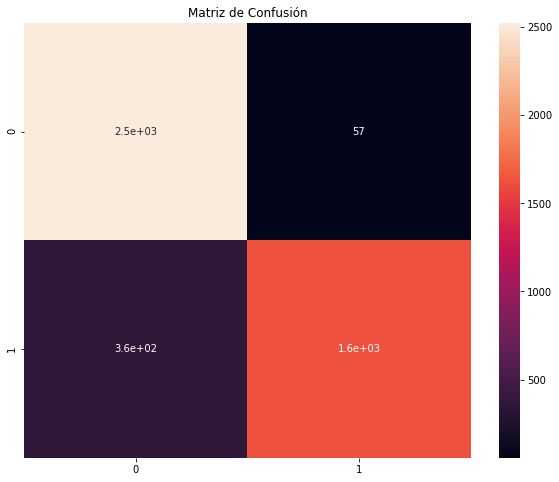

In [85]:
print(classification_report(y_test, y_hat))

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True);
plt.savefig('confusion_matrix.png');
plt.title('Matriz de Confusión');

## 10) Interpretación de resultados.
Como podemos observar, el modelo clasifica bastante bien, con un $91\%$ de casos acertados sobre el total, es decir, _accuracy_.

Además, tenemos muy buena _precision,_ lo que significa que tenemos pocos falsos positivos. En otras palabras, el modelo rara vez confunde una fake new como verídica.

Por otra parte, la recall se encuentra en niveles tolerables. Esto implica que a costas de clasificar bien las noticias verídicas, hay un $20\%$ de éstas que las clasificamos como fake.

In [87]:
text = 'A talk radio host said he was fired from a rightwing radio station – mid-show – for criticizing Donald Trump. Craig Silverman was hosting his eponymous show on 710 KNUS, a Denver station owned by the conservative Salem Media Group, on Saturday when the station abruptly cut to a network news report. According to Silverman, the program director entered the studio and told him: “You’re done.” Silverman had been in the middle of a segment about Roy Cohn, Trump’s controversial former lawyer who died in 1986. Silverman, a rare critic of Trump on the conservative network, said he had run into problems with executives at the station due to his refusal to “toe strict Trump party line”. “I was frustrated that we couldn’t talk about the facts of the impeachment case and it all came to a head as I was excoriating Donald Trump on my show yesterday,” Silverman told CNN’s Reliable Sources on Sunday. On Sunday night, however, KNUS said Silverman was not fired – despite the station removing his page from its website – but was taken off air after he discussed a planned appearance on a rival network. “He decided that it was important to work across town and so on Saturday on his program he announced that, and that’s what prompted our decision to take him off the air,” station general manager Brian Taylor told the Denver Post.“The notion that he was relieved from his program because he criticized President Trump is absolutely untrue. We’ve never told Mr Silverman the position to take on [Trump’s] impeachment.” Speaking to CNN Business, Silverman outlined his position, discussing the witnesses who appeared in public hearings last week. “I thought [William] Taylor and [George] Kent were great,” he said, “they laid a base. I’m a trial attorney, I’m a former prosecutor. I know how to put on a case. As of Monday morning, he had not said whether he would return to his show. Taylor said: “I look forward to Craig continuing his program.”'
print(len(text), '\n' , text)

1943 
 A talk radio host said he was fired from a rightwing radio station – mid-show – for criticizing Donald Trump. Craig Silverman was hosting his eponymous show on 710 KNUS, a Denver station owned by the conservative Salem Media Group, on Saturday when the station abruptly cut to a network news report. According to Silverman, the program director entered the studio and told him: “You’re done.” Silverman had been in the middle of a segment about Roy Cohn, Trump’s controversial former lawyer who died in 1986. Silverman, a rare critic of Trump on the conservative network, said he had run into problems with executives at the station due to his refusal to “toe strict Trump party line”. “I was frustrated that we couldn’t talk about the facts of the impeachment case and it all came to a head as I was excoriating Donald Trump on my show yesterday,” Silverman told CNN’s Reliable Sources on Sunday. On Sunday night, however, KNUS said Silverman was not fired – despite the station removing his 

In [89]:
forest.predict(vectorizer.transform([text]))

array([0])

## 11) Exportación del modelo

Pickletizamos el modelo y el vectorizador en archivos binarios de pickle para poder levantarlos en un servidor.

In [13]:
import os
import pickle
with open ('model.pkl', 'wb') as f:
    pickle.dump(forest, f)

In [14]:
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [90]:
ext = ExtraTreesClassifier(n_estimators=1000, n_jobs=20)
ext.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=20,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [91]:
y_hat = ext.predict(X_test)

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      2579
           1       0.98      0.78      0.87      1993

    accuracy                           0.90      4572
   macro avg       0.92      0.88      0.89      4572
weighted avg       0.91      0.90      0.89      4572



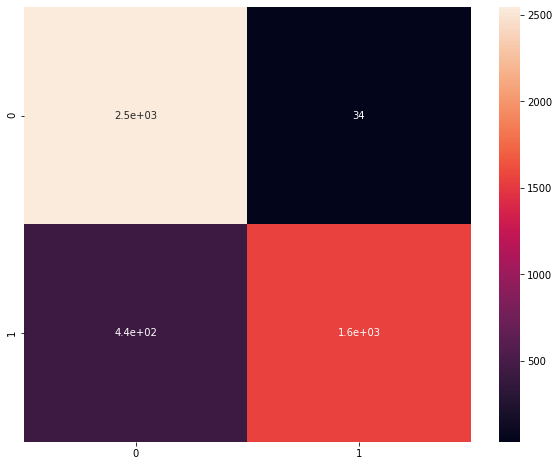

In [92]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True)
print(classification_report(y_test, y_hat))